In [1]:
from torchvision import datasets
from torch.utils.data import Dataset,DataLoader
from torchvision.utils import save_image
from skimage.util import random_noise
from PIL import Image
from augraphy import *
import numpy as np
import torch
import torchvision.transforms as transforms
import os
import random
import cv2

/home/ocr/anaconda3/envs/teluguOCR/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
dir = '/home/ocr/teluguOCR/Dataset/Images/'
noisepath = '/home/ocr/teluguOCR/Dataset/Cropped_Dataset/Images'
transcript = '/home/ocr/teluguOCR/Dataset/labels.txt'

In [4]:
# Define the transformation to convert the images to tensors and perform any other necessary preprocessing
transform = transforms.Compose([
    transforms.ToPILImage(),  # Ensure PIL
    transforms.ToTensor()  # Convert to a PyTorch tensor
])

In [5]:
# load the txt file and read the file line by line.
def read_file_lines(filename, startline, endline):
    lines = []
    try:
        with open(filename, 'r') as file:
            currentline = 1
            while currentline < startline:
              temp = file.readline()
              currentline += 1
            for line in file:
                lines.append(line.strip())  # Remove trailing newline characters
                currentline += 1
                if currentline > endline:
                  break
        # print(currentline, endline)
    except FileNotFoundError:
        print(f"File '{filename}' not found.")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

    return lines

In [6]:
# Function to add Gaussian noise to an image
def add_gaussian_noise(img):
  gauss_img = torch.tensor(random_noise(img, mode='gaussian', mean=0, var=0.01, clip=True))
  return gauss_img

# Function to add salt and pepper noise to an image
def add_salt_and_pepper_noise(img):
  s_and_p_img = torch.tensor(random_noise(img, mode='s&p', salt_vs_pepper=0.1, clip=True))
  return s_and_p_img

# Function to add speckle noise to an image
def add_speckle_noise(img):
  speckle_noise_img = torch.tensor(random_noise(img, mode='speckle', mean=0, var=0.01, clip=True))
  return speckle_noise_img

# Function to add dirty drum roll noise to an image
add_dirty_drum_noise = DirtyDrum(ksize=(3,3))

# Function to add dirtyroller noise to an image
add_dirty_roller_noise = DirtyRollers()

# Function to add motion blur to an image
def add_motion_blur(img):
  kernel_size = 4
  angle = np.random.uniform(0, 45)
  kernel_v = np.zeros((kernel_size, kernel_size)) 
  kernel_h = np.copy(kernel_v) 
  kernel_v[:, int((kernel_size - 1)/2)] = np.ones(kernel_size) 
  kernel_h[int((kernel_size - 1)/2), :] = np.ones(kernel_size) 
  kernel_v /= kernel_size 
  kernel_h /= kernel_size
  kernel = ((angle/90)*kernel_v + (1-(angle/90))*kernel_h)
  mb_image = cv2.filter2D(img, -1, kernel)
  return mb_image


In [7]:
count = 0
for i in range(1, 30001):
    print(i)
    imagename = "Image" + str(i) + ".png"
    image = cv2.imread(os.path.join(dir, imagename), cv2.IMREAD_GRAYSCALE)
    image = np.array(image)
    image = transform(image)

    random_subset = [random.randint(0, 2)]

    # Apply the selected noise functions to the image based on the random subset
    for noise_type in random_subset:
        if noise_type == 0:
            image = add_gaussian_noise(image)
            image = image*255
        elif noise_type == 1:
            image = add_dirty_roller_noise(cv2.imread(os.path.join(dir , imagename), cv2.IMREAD_GRAYSCALE))
            image = torch.tensor(image)
        elif noise_type == 2:
            image = add_motion_blur(cv2.imread(os.path.join(dir, imagename), cv2.IMREAD_GRAYSCALE))
            image = torch.tensor(image)
    
    image = image.to(dtype=torch.float64)

    if(image.shape[0] == 1):
        image = image[0]

    print(torch.max(image), " | ", torch.min(image))

    save_path = f'{noisepath}/' + "Image" + str(1000*count + i) + ".pt"
    torch.save(image,save_path)
    del image
    del random_subset
    del save_path
    del imagename
    del noise_type
    

1
tensor(255., dtype=torch.float64)  |  tensor(0., dtype=torch.float64)


RuntimeError: Parent directory /home/ocr/teluguOCR/Dataset/Noised_Images does not exist.

tensor(1., dtype=torch.float64) tensor(0., dtype=torch.float64)
gauss_image


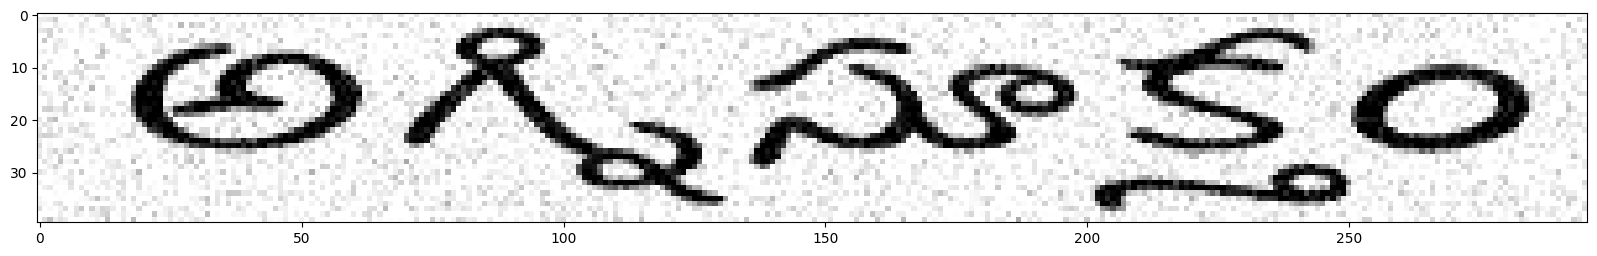

s_and_p_image
tensor(1.) tensor(0.)


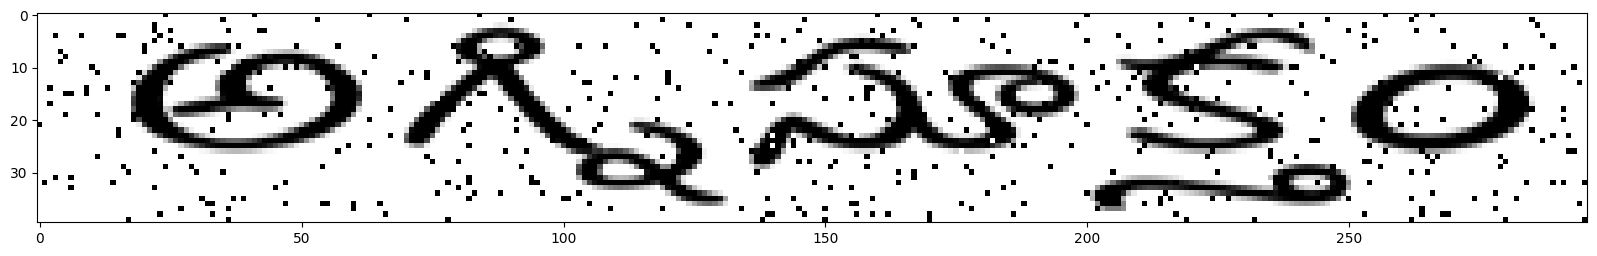

speckle_image
tensor(1., dtype=torch.float64) tensor(0., dtype=torch.float64)


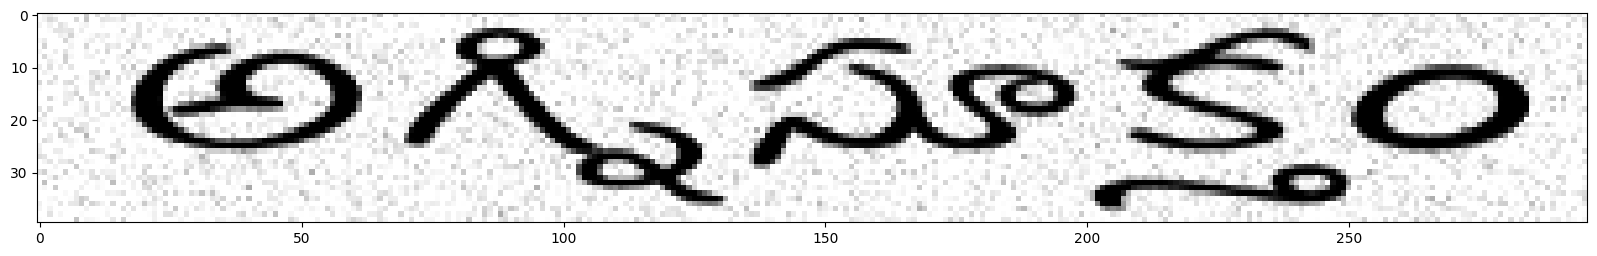

dirty_drum_image
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)


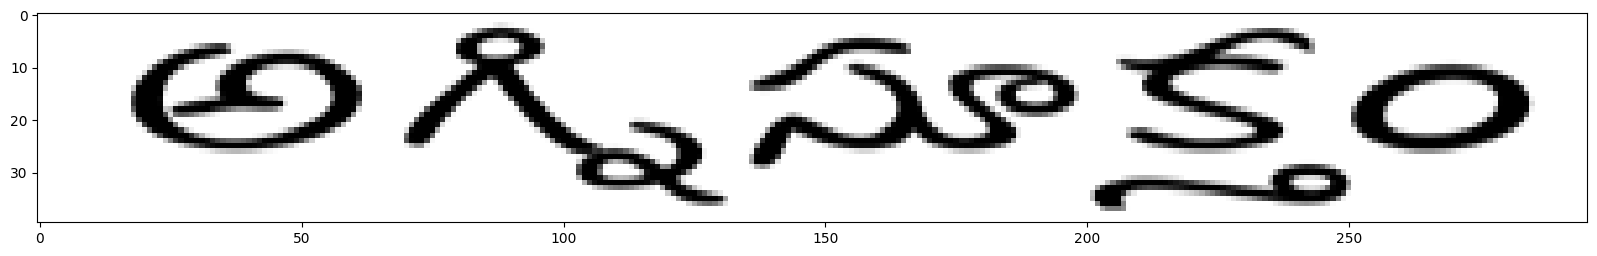

dirty_roller_image
tensor(252, dtype=torch.uint8) tensor(0, dtype=torch.uint8)


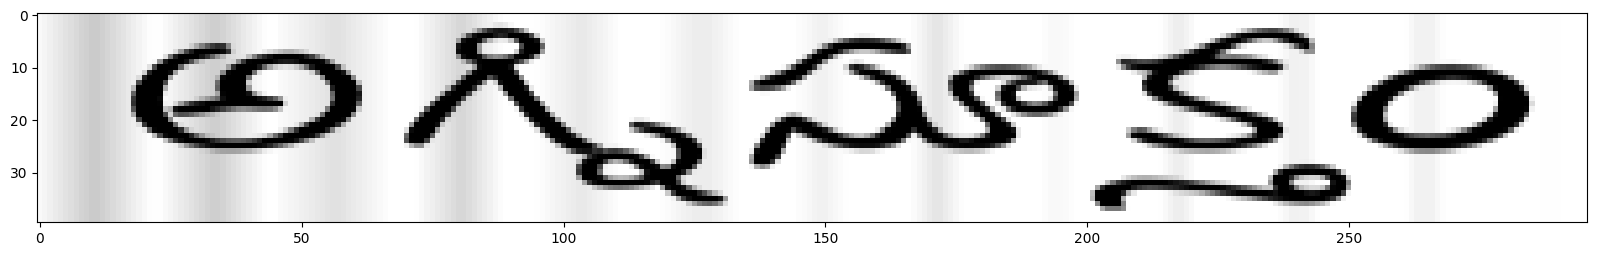

motion_blur_image
tensor(255, dtype=torch.uint8) tensor(0, dtype=torch.uint8)


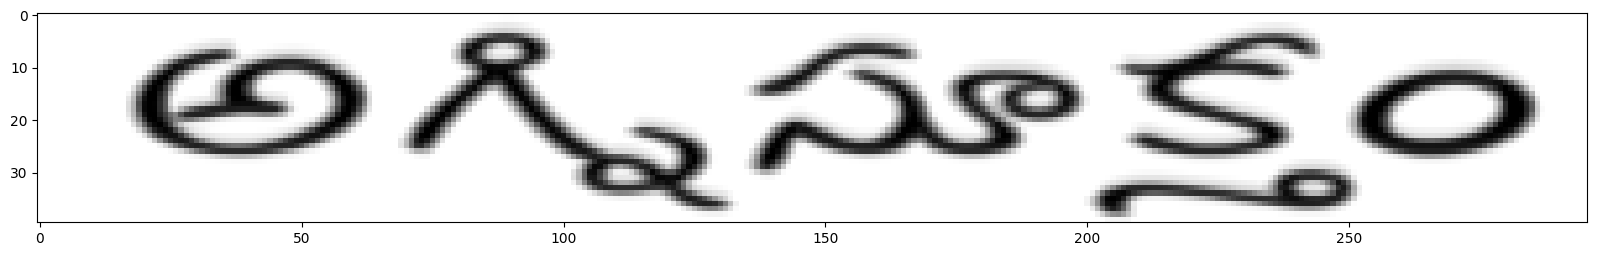

tensor(1.) tensor(0.)


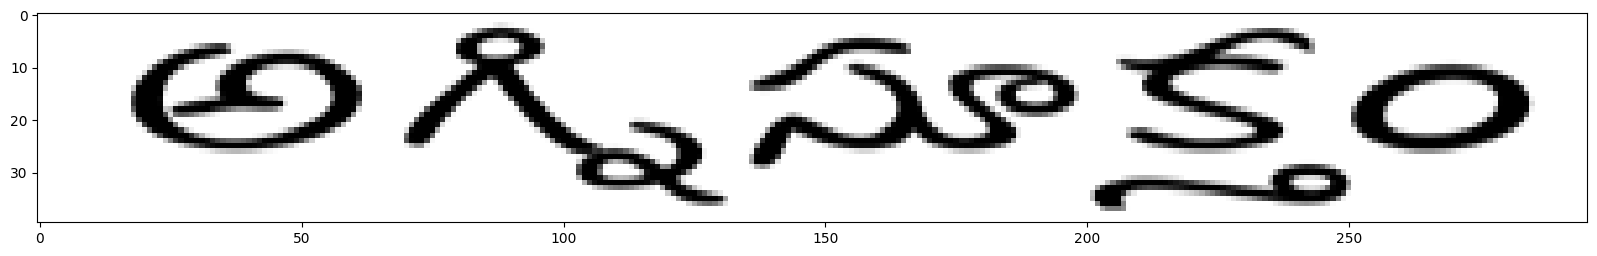

In [8]:
og_image = cv2.imread("../teluguOCR/Dataset/Images/Image1.png", cv2.IMREAD_GRAYSCALE)
og_image = transform(og_image)


# gaussian noise
plt.figure(figsize=(20,20))
gauss_image = add_gaussian_noise(og_image)
print(torch.max(gauss_image), torch.min(gauss_image))
print("gauss_image")
plt.imshow(gauss_image[0], cmap='gray')
plt.show()

# salt and pepper noise
plt.figure(figsize=(20,20))
s_and_p_image = add_salt_and_pepper_noise(og_image)
print("s_and_p_image")
print(torch.max(s_and_p_image), torch.min(s_and_p_image))
plt.imshow(s_and_p_image[0], cmap='gray')
plt.show()

# speckle noise
plt.figure(figsize=(20,20))
speckle_image = add_speckle_noise(og_image)
print("speckle_image")
print(torch.max(speckle_image), torch.min(speckle_image))
plt.imshow(speckle_image[0], cmap='gray')
plt.show()

# dirty drum noise
plt.figure(figsize=(20,20))
dirty_drum_image = add_dirty_drum_noise(cv2.imread("../teluguOCR/Dataset/Images/Image1.png", cv2.IMREAD_GRAYSCALE))
dirty_drum_image = torch.tensor(dirty_drum_image)
print("dirty_drum_image")
print(torch.max(dirty_drum_image), torch.min(dirty_drum_image))
plt.imshow(dirty_drum_image, cmap='gray')
plt.show()

# dirty roller noise
plt.figure(figsize=(20,20))
dirty_roller_image = add_dirty_roller_noise(cv2.imread("../teluguOCR/Dataset/Images/Image1.png", cv2.IMREAD_GRAYSCALE))
dirty_roller_image = torch.tensor(dirty_roller_image)
print("dirty_roller_image")
print(torch.max(dirty_roller_image), torch.min(dirty_roller_image))
plt.imshow(dirty_roller_image, cmap='gray')
plt.show()

# motion blur
plt.figure(figsize=(20,20))
motion_blur_image = add_motion_blur(cv2.imread("../teluguOCR/Dataset/Images/Image1.png", cv2.IMREAD_GRAYSCALE))
motion_blur_image = torch.tensor(motion_blur_image)
print("motion_blur_image")
print(torch.max(motion_blur_image), torch.min(motion_blur_image))
plt.imshow(motion_blur_image, cmap='gray')
plt.show()

plt.figure(figsize=(20,20))
print(torch.max(og_image), torch.min(og_image))
plt.imshow(og_image[0], cmap='gray')
plt.show()


In [ ]:
img = cv2.imread('../teluguOCR/Dataset/Images/Image1.png') 

kernel_size = 5
angle = np.random.uniform(0, 45)
print(angle)
kernel_v = np.zeros((kernel_size, kernel_size)) 
kernel_h = np.copy(kernel_v) 
kernel_v[:, int((kernel_size - 1)/2)] = np.ones(kernel_size) 
kernel_h[int((kernel_size - 1)/2), :] = np.ones(kernel_size) 
kernel_v /= kernel_size 
kernel_h /= kernel_size
kernel = ((angle/90)*kernel_v + (1-(angle/90))*kernel_h)
mb_image = cv2.filter2D(img, -1, kernel)


plt.figure(figsize=(20,20))
plt.imshow(mb_image, cmap='gray')
plt.show()

 CHECKING THE MAPPING

In [ ]:
# load the txt file and read the file line by line.
def read_file_lines(filename):
    lines = []
    try:
        with open(filename, 'r') as file:
            for line in file:
                lines.append(line.strip())  # Remove trailing newline characters
    except FileNotFoundError:
        print(f"File '{filename}' not found.")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

    return lines


In [ ]:
plt.figure(figsize=(20,20))
img = torch.load('/home/ocr/teluguOCR/Dataset/Noised_Images/Image18073.pt')
print(img.shape)

plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
import torch 
import matplotlib.pyplot as plt
import cv2 as cv

for i in range(1, 30001):
    # Load the image
    image = torch.load('/home/ocr/teluguOCR/Dataset/Noised_Images/Image' + str(i) + '.pt')
    og = cv.imread("../teluguOCR/Dataset/Images/Image" + str(i) + ".png", cv.IMREAD_GRAYSCALE)
    label = read_file_lines('/home/ocr/teluguOCR/Dataset/strings.txt')

    label = label[i-1]

    # print(torch.max(image), torch.min(image))

    if(len(image.shape) == 2):
        image = image.unsqueeze(0)
        torch.save(image, '/home/ocr/teluguOCR/Dataset/Noised_Images/Image' + str(i) + '.pt')

    # print(image.shape)
        
    # Convert the image to a NumPy array
    # image = image.numpy()

    

    # # Plot the image
    # plt.figure(figsize=(10, 10))
    # plt.imshow(og, cmap='gray')
    # plt.show()

    # plt.figure(figsize=(10, 10))
    # plt.imshow(image[0], cmap='gray')
    # plt.show()
    # print(label)




In [ ]:
# labels1 = read_file_lines('/home/ocr/teluguOCR/Dataset/labels_1.txt')
# labels2 = read_file_lines('/home/ocr/teluguOCR/Dataset/labels_2.txt')
# labels3 = read_file_lines('/home/ocr/teluguOCR/Dataset/labels_3.txt')
# labels4 = read_file_lines('/home/ocr/teluguOCR/Dataset/labels_4.txt')
# labels5 = read_file_lines('/home/ocr/teluguOCR/Dataset/labels_5.txt')

# print(len(labels1), len(labels2), len(labels3), len(labels4), len(labels5))
# print(len(labels1) + len(labels2) + len(labels3) + len(labels4) + len(labels5))